In [2]:
import numpy as np
import math
import os
import gdal
import xarray as xr
from skimage.measure import block_reduce
from ftplib import FTP
import subprocess
import rioxarray
import time as T
import datetime
import ephem
import numpy.ma as ma
import datetime as dt
from joblib import Parallel, delayed

def calc_sunpos(dtime,lat,lon):
    sun = ephem.Sun()
    obs = ephem.Observer()
    obs.date = dtime
    obs.lat = lat*math.pi/180.0
    obs.long = lon*math.pi/180.0
    sun.compute(obs)
    return np.degrees(sun.az),90.0-np.degrees(sun.alt)


class SGLI_L2_Downloader:
    
    def __init__ (self, User_ID , ProductName, Ver, Date , Tile , Obrit ,ParaVer, Target_path):
        self.User_ID = User_ID
        self.ProductName = ProductName
        self.Ver = Ver
        self.Date = Date
        self.Tile = Tile
        self.Obrit = Obrit
        self.ParaVer = ParaVer
        self.Target_path = Target_path
        
        
    def path (self):
        return '/standard/GCOM-C/GCOM-C.SGLI/L2.LAND.{}/{}/{}/{}/{}'.format(self.ProductName, self.Ver, self.Date[0:4], self.Date[4:6], self.Date[6:8])

    def filename (self):
        return 'GC1SG1_{}{}01D_T{}_L2SG_{}Q_{}00{}.h5'.format(self.Date, self.Obrit, self.Tile, self.ProductName, self.Ver, self.ParaVer)
    
    def login (self):
        ftp_addr = 'ftp.gportal.jaxa.jp'
        f = FTP(ftp_addr)
        f.login(self.User_ID,'anonymous')
        
        return f
    
    def download (self, f):
        remote_filepath = self.path()
        f.cwd(remote_filepath)
        list=f.nlst()
        
        bufsize=1024
        if self.filename() in list:
            data = open ('{}{}'.format(self.Target_path, self.filename()), 'wb')
            filename = 'RETR ' + self.filename()
            f.retrbinary(filename,data.write,bufsize)
            return 'y'
        else:
            return 'n'
    
    def logout (self, f):
        f.quit()
    
def reporjection_GEO(filename,Band,Target_path):
    
    #print(path)
    p = subprocess.Popen('/data01/people/liwei/Data/GCOM-C_RSRF/SGLI_geo_map_linux.exe {} -d Geometry_data/{} -o {} -s 7.5'.format(filename,Band,Target_path[:-1]),shell=True)
    p.communicate()
    # subprocess.check_output('/data01/people/liwei/Data/GCOM-C_RSRF/SGLI_geo_map_linux.exe {} -d Geometry_data/{} -o {} -s 7.5'.format(filename,Band,Target_path[:-1]), shell=True) 
    
def mkdir(path):
    folder = os.path.exists(path) 
    if not folder:
        os.makedirs(path)
        
    
def SGLI_2_AHI_GEO(filepath,lat,lon):  
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != -32768:
        data = data * 0.01
        return data
    else:
        return np.nan
def SGLI_2_AHI_TIME(filepath,lat,lon):
    geotiff_da = rioxarray.open_rasterio(filepath)
    data = geotiff_da.interp(x=lon,y=lat,method="nearest")
    if data != -32768.:
        data = data * 0.001
        return data
    else:
        return np.nan

def download_tile(date,save_tile_path,tile):
    g = SGLI_L2_Downloader(
        'galiwei ' ,
        'RSRF', 
        '3', 
         date , 
         tile, 
        'D' , 
        '1' ,
         save_tile_path
        )
    f = g.login()
    
    if os.path.exists(save_tile_path + g.filename()):
        return g.filename()
    
    else :
        rc = g.download(f)
        if rc == 'n':
            g.logout(f)
            return 'n'
        else:
            g.logout(f)
            return g.filename()
    
def download_AHI(target_path , date, time, angle):
    
    date1 = date[0:6]
    date2 = date
    AHI_date = date2 + time
    sza_file_name = '{}.sun.zth.fld.4km.bin.bz2'.format(AHI_date)
    saa_file_name = '{}.sun.azm.fld.4km.bin.bz2'.format(AHI_date)
    
    
    if angle == 'sza':
        if os.path.exists(target_path + sza_file_name[:-4]):
            return sza_file_name[:-4]
    
        else:
            ftp = FTP()
            ftp.connect('hmwr829gr.cr.chiba-u.ac.jp', 21)
            ftp.login()
            path = '/gridded/FD/V20190123/{}/4KM/{}/'.format(date1,date2)
            ftp.cwd(path)
            remote_list=ftp.nlst()
            bufsize=1024*1024
            if sza_file_name in remote_list:
                data = open(target_path + sza_file_name,'wb')
                filename='RETR '+ sza_file_name
                ftp.retrbinary(filename,data.write,bufsize)
                ftp.quit()

                return sza_file_name[:-4]
            else:
#                 print('AHI NO DATA')
                return None
        
    elif angle == 'saa':
        if os.path.exists(target_path + saa_file_name[:-4]):
            return saa_file_name[:-4]
    
        else:
            ftp = FTP()
            ftp.connect('hmwr829gr.cr.chiba-u.ac.jp', 21)
            ftp.login()
            path = '/gridded/FD/V20190123/{}/4KM/{}/'.format(date1,date2)
            ftp.cwd(path)
            remote_list=ftp.nlst()
            bufsize=1024*1024
            if saa_file_name in remote_list:
                data = open(target_path + saa_file_name,'wb')
                filename='RETR '+ saa_file_name
                ftp.retrbinary(filename,data.write,bufsize)
                ftp.quit()
                return saa_file_name[:-4]
            else:
#                 print('AHI NO DATA')
                return None
    
def Decompression(t,fn):
    if os.path.exists('{}.bz2'.format(t + fn)):
        p = subprocess.Popen('lbzip2 -d {}.bz2'.format(t + fn),shell=True)
        p.communicate()
        
def ahi_lon_timeoffset(lon): 
    lon_interval = 15 
    UTC_e_lon = lon_interval / 2 
    timeoffset = math.ceil((lon - UTC_e_lon) / lon_interval) 
    return timeoffset 
        
def Time_split(time):
    YYYY = time.strftime('%Y')
    MM = time.strftime('%m')
    DD = time.strftime('%d')
    HH = time.strftime('%H')
    MIN = time.strftime('%M')
    date = YYYY + MM + DD
    return YYYY,MM,DD,HH,MIN,date

# class AHI_angle:
#     def __init__(self,date,lat,lon):
#         self.date = date      
#         self.lon = lon
#         self.lat = lat
        
#     def read_angle_data(self):
#         row_u_4KM = round((60 - self.lat)/0.04)
#         col_l_4KM = round((self.lon - 85)/0.04)
        
        
#         AHI_date = self.date[4:11]
        
#         sza_file_name = 'AHI_SZA_2020{}5.dat'.format(AHI_date)
#         saa_file_name = 'AHI_SAA_2020{}5.dat'.format(AHI_date)
        
#         with open(SZA_PATH + sza_file_name,'rb') as fp:
#             AHI_SZA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000)[row_u_4KM , col_l_4KM] / 100
        
#         with open(SAA_PATH + saa_file_name,'rb') as fp:
#             AHI_SAA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000)[row_u_4KM , col_l_4KM] / 100
        
#         return AHI_SZA,AHI_SAA
    
    
def lonlat2tileidx(latlon:tuple)->tuple:
    # vertical pixel count in one tile, horizontal pixel count in one tile
    lintile, coltile = 1200, 1200
    # vertical tile count, horizontal tile count
    vtilenum, htilenum = 18, 36
    # [deg/pixel]
    d = 180.0/lintile/vtilenum
    # from S-pole to N-pole
    NL = 180.0/d
    NP0 = 2*np.round(180.0/d)
    res1 = (90 - latlon[0])/d-0.5
    V_idx = res1 // lintile
    # Y_idx = res1 - V_idx * lintile
    # GCOM-C use integer NPi
    NPi = round(NP0*np.cos(np.deg2rad(latlon[0])))
    res2 = latlon[1]*NPi/360 - 0.5 + NP0/2
    H_idx = res2 // coltile
    # X_idx = res2 - H_idx * coltile
    return str(round(V_idx)).rjust(2,'0')  + str(round(H_idx)).rjust(2,'0') 

In [3]:
year = ['2020']


MM = ['05','06']
DD=['01','02','03','04','05','06','07','08','09','10',\
    '11','12','13','14','15','16','17','18','19','20',\
    '21','22','23','24','25','26','27','28','29','30',\
    '31']
HH=['09','10','11']
MIN=['00','10','20','30','40','50']

band = ['Sensor_zenith_PL', 'Sensor_azimuth_PL','Obs_time_PL']


MATCH_RESULT = []
#Save path
reporjection_file_path = '/data01/people/liwei/Data/GCOM-C_RSRF/reporjection/'
tile_file_path = '/data01/people/liwei/Data/GCOM-C_RSRF/tile/'
SZA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Zenith_Angle_u2/'
SAA_PATH = '/data01/GEO/INPUT/ANGLE/Solar_Azimuth_Angle_u2/'

VZA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Zenith_Angle/AHI_VZA_10.dat'
VAA_PATH = '/data01/GEO/INPUT/ANGLE/Viewer_Azimuth_Angle/AHI_VAA_10.dat'
LAND_MASK_PATH = '/data01/GEO/INPUT/LAND_MASK/Landmask_10.dat'

# AHI VZA/VAA Load
with open(VZA_PATH,'rb') as fp:
    AHI_VZA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100
with open(VAA_PATH,'rb') as fp:
    AHI_VAA = np.frombuffer(fp.read(),dtype='u2').reshape(12000,12000) / 100

with open(LAND_MASK_PATH,'rb') as fp:
    LAND_MASK = np.frombuffer(fp.read(),dtype='u1').reshape(12000,12000).astype('bool')


In [4]:

MASK_AHI = ma.array(data = AHI_VZA, mask = ~LAND_MASK, fill_value = np.nan).filled()
PART1 = MASK_AHI[0:3000,:]
PART2 = MASK_AHI[9000:,:]
PART1_MASK_FULL = np.where(PART1>47,PART1,np.nan)
PART1_MASK_FULL = np.where(PART1_MASK_FULL<68,PART1_MASK_FULL,np.nan)
PART2_MASK_FULL = np.where(PART2>47,PART2,np.nan)
PART2_MASK_FULL = np.where(PART2_MASK_FULL<68,PART2_MASK_FULL,np.nan)
PART1_MASK_FULL = np.where(np.isnan(PART1_MASK_FULL),0,1)
PART2_MASK_FULL = np.where(np.isnan(PART2_MASK_FULL),0,1)

NameError: name 'PART1_MASK' is not defined

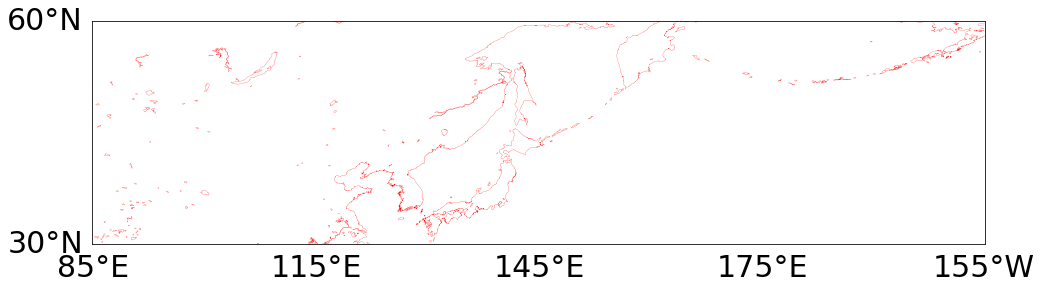

In [4]:

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(16,16))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=30, urcrnrlat = 60,
            llcrnrlon=85, urcrnrlon = 205)  

m.drawcoastlines(linewidth=0.2,color='r')
m.drawparallels(np.arange(30, 61, 30), labels=[1,0,0,0], fontsize=30,linewidth=0)
m.drawmeridians(np.arange(85, 206, 30), labels=[0,0,0,1], fontsize=30,linewidth=0)

m.imshow(PART1_MASK,origin='upper',cmap = 'gray',interpolation = None)
cb = m.colorbar()

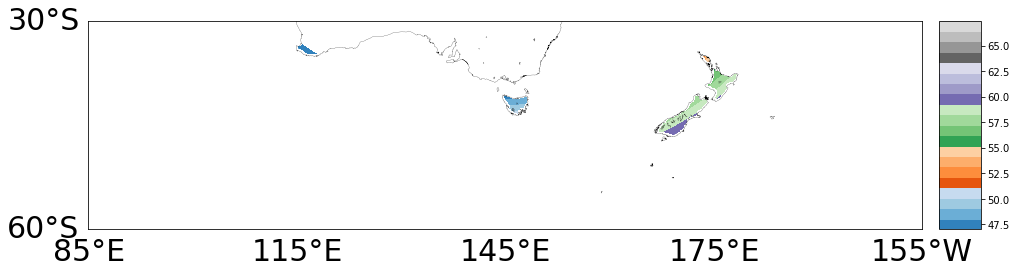

In [44]:
fig = plt.figure(figsize=(16,16))
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=-60, urcrnrlat = -30,
            llcrnrlon=85, urcrnrlon = 205)  

m.drawcoastlines(linewidth=0.2)
m.drawparallels(np.arange(-60, -29, 30), labels=[1,0,0,0], fontsize=30,linewidth=0)
m.drawmeridians(np.arange(85, 206, 30), labels=[0,0,0,1], fontsize=30,linewidth=0)

m.imshow(PART2_MASK,origin='upper',cmap = 'tab20c',interpolation = None)
cb = m.colorbar()

In [5]:
res = 0.01
u_lat,d_lat = 60,30
l_lon,r_lon = 85,205

row_AHI = 3000
col_AHI = 12000


AHI_lat_FULL = np.linspace(60 - res/2 ,30 + res/2,row_AHI)
AHI_lon_FULL = np.linspace(85 + res/2 ,205 - res/2,col_AHI)

MATCH_RESULT = []
TIME_MATCH = datetime.timedelta(minutes = 10)

# TEST

In [23]:
PART1_MASK = PART1_MASK_FULL[1600:1700,5800:6000]
AHI_lat = AHI_lat_FULL[1400:1500]
AHI_lon = AHI_lon_FULL[5800:6000]

In [25]:
PART1_MASK = PART1_MASK_FULL
AHI_lat = AHI_lat_FULL
AHI_lon = AHI_lon_FULL

In [8]:
class AHI_angle:
    def __init__(self,date,lat,lon):
        self.date = date      
        self.lon = lon
        self.lat = lat
        
    def read_angle_data(self):
        row_u_4KM = round((60 - self.lat)/0.04)
        col_l_4KM = round((self.lon - 85)/0.04)
        
        
        AHI_date = self.date[4:11]
        
        sza_file_name = 'AHI_SZA_2020{}5.dat'.format(AHI_date)
        saa_file_name = 'AHI_SAA_2020{}5.dat'.format(AHI_date)
        
        with open(SZA_PATH + sza_file_name,'rb') as fp:
            AHI_SZA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000)[row_u_4KM , col_l_4KM] / 100
        
        with open(SAA_PATH + saa_file_name,'rb') as fp:
            AHI_SAA = np.frombuffer(fp.read(),dtype='u2').reshape(3000,3000)[row_u_4KM , col_l_4KM] / 100
        
        return AHI_SZA,AHI_SAA
def SGLI_SA(h,_min,lat,lon):

    d = datetime.datetime(int(YYYY),int(MM),int(DD),h,_min)
    
    SAA,SZA = calc_sunpos(d,lat,lon)
    return SAA,SZA

In [9]:
Tile_list = ['0324','0325','0326','0327','0328','0424','0425','0426','0427','0428','0525','0526','0527']
def SGLI_Download_Reprojection(i):
    
    # SGLI 文件名
    SGLI_tile_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001.h5'.format(date,Tile_list[i])
    SGLI_VZA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_zenith_PL.tif'.format(date,Tile_list[i])
    SGLI_VAA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_azimuth_PL.tif'.format(date,Tile_list[i])
    SGLI_TIME_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Obs_time_PL.tif'.format(date,Tile_list[i])


    # 下载SGLI并重投影

    if not os.path.exists(tile_file_path + SGLI_tile_filename):
        print('Start SGLI Download and Reporjection ' + SGLI_tile_filename)
        fn = download_tile(date,tile_file_path,tile) 
        if fn == 'n':
            return None
    else:
        if not os.path.exists(reporjection_file_path + SGLI_VZA_filename):
            reporjection_GEO( tile_file_path+SGLI_tile_filename , 'Sensor_zenith_PL' , reporjection_file_path)
        if not os.path.exists(reporjection_file_path + SGLI_VAA_filename):
            reporjection_GEO( tile_file_path+SGLI_tile_filename , 'Sensor_azimuth_PL' , reporjection_file_path)
        if not os.path.exists(reporjection_file_path + SGLI_TIME_filename):
            reporjection_GEO( tile_file_path+SGLI_tile_filename , 'Obs_time_PL' , reporjection_file_path)
                
    # return SGLI_VZA_filename,SGLI_VAA_filename,SGLI_TIME_filename

In [10]:
def Find_Matching(lat_idx,lon_idx):
    if PART1_MASK[lat_idx,lon_idx] == 1:
        # 获取该经纬度的Tile号
        # print(lat_idx,lon_idx) 
        row_AHI = round((60 - AHI_lat[lat_idx])/0.01)
        col_AHI = round((AHI_lon[lon_idx] - 85)/0.01)

        AHI_VZA_PIXEL = AHI_VZA[row_AHI,col_AHI]
        AHI_VAA_PIXEL = AHI_VAA[row_AHI,col_AHI]

        tile = lonlat2tileidx([AHI_lat[lat_idx],AHI_lon[lon_idx]])
        # print(tile) 
        # SGLI 文件名
        SGLI_tile_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001.h5'.format(date,tile)
        SGLI_VZA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_zenith_PL.tif'.format(date,tile)
        SGLI_VAA_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Sensor_azimuth_PL.tif'.format(date,tile)
        SGLI_TIME_filename = 'GC1SG1_{}D01D_T{}_L2SG_RSRFQ_3001_Obs_time_PL.tif'.format(date,tile)

        # 存在SGLI文件
        if os.path.exists(tile_file_path + SGLI_tile_filename):

            # 读取该像素经纬度SGLI的VZA和VAA
            SGLI_VZA_PL = SGLI_2_AHI_GEO(reporjection_file_path + SGLI_VZA_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
            SGLI_VAA_PL = SGLI_2_AHI_GEO(reporjection_file_path + SGLI_VAA_filename,AHI_lat[lat_idx],AHI_lon[lon_idx]) + 180
            if not np.isnan(SGLI_VZA_PL) and not np.isnan(SGLI_VAA_PL):

            # 计算该像素经纬度SGLI的SZA和SAA

                SGLI_Obs_TIME = SGLI_2_AHI_TIME(reporjection_file_path + SGLI_TIME_filename,AHI_lat[lat_idx],AHI_lon[lon_idx])
                SGLI_MIN = int(round(math.modf(SGLI_Obs_TIME)[0],3)*60)
                SGLI_HH = int(math.modf(SGLI_Obs_TIME)[1])
                SGLI_SAA_PL,SGLI_SZA_PL = SGLI_SA(SGLI_HH,SGLI_MIN,AHI_lat[lat_idx],AHI_lon[lon_idx])

                # 读取SGLI观测时间 最接近的AHI观测时间
                AHI_time = YYYY + MM + DD + str(SGLI_HH).rjust(2,'0')  + str(int(round(SGLI_MIN/10)))+'0'
                # AHI_dtime = datetime.datetime.strptime('{}-{}-{} {}:{}'.format(YYYY,MM,DD,str(SGLI_HH),str(int(round(SGLI_MIN/10)))+'0'), '%Y-%m-%d %H:%M')
                
                # 读取AHI的SZA、SAA
                AHI_SZA,AHI_SAA = AHI_angle(AHI_time,AHI_lat[lat_idx],AHI_lon[lon_idx]).read_angle_data()  

                # print('AHI_VZA:{} SGLI_VZA:{}'.format(AHI_VZA_PIXEL,))
                # print('AHI_VAA:{} SGLI_VAA:{}'.format(AHI_VAA_PIXEL,SGLI_VAA_PL.data[0]))
                # print('AHI_SZA:{} SGLI_SZA:{}'.format(AHI_SZA,SGLI_SZA_PL))
                # print('AHI_SAA:{} SGLI_SAA:{}'.format(AHI_SAA,SGLI_SAA_PL))
                # print('AHI obs_time:{} SGLI obs_time:{}'.format(AHI_time[8:],str(SGLI_HH).rjust(2,'0') + str(SGLI_MIN)))
                # print('\n')
                
                
                # Scattering_Angle = -cos(GEO_VZA) * cos(LEO_VZA) - cos(GEO_VAA - LEO_VAA) * sin(GEO_VZA) * sin(LEO_VZA)
                Scattering_Angle = -math.cos(np.radians(AHI_VZA_PIXEL)) * math.cos(np.radians(SGLI_VZA_PL.data[0])) - math.cos(np.radians(AHI_VAA_PIXEL - SGLI_VAA_PL.data[0])) * math.sin(np.radians(AHI_VZA_PIXEL)) * math.sin(np.radians(SGLI_VZA_PL.data[0]))
                
                
                
                if Scattering_Angle != None :
                    return np.degrees(np.arccos(Scattering_Angle)),[AHI_time[8:],str(SGLI_HH).rjust(2,'0') + str(SGLI_MIN)]
                else :
                    return np.nan,[]
            else:
                return np.nan,[]
        else:
            return np.nan,[]
    else:        
        return np.nan,[]


In [ ]:
date_start = '2020-01-12 00:00'
date_end = '2020-01-12 23:50'
date_t = dt.timedelta(days=1)
date_s = dt.datetime.strptime(date_start, "%Y-%m-%d %H:%M")
date_e = dt.datetime.strptime(date_end, "%Y-%m-%d %H:%M")
date_time_now = date_s
while date_time_now <= date_e:
    start_time = T.time()
    date_dl_str = date_time_now.strftime("%Y-%m-%d %H:%M" )
    YYYY,MM,DD,HH,MIN,date= Time_split(date_time_now)
    print(date_time_now)
    for t in range(len(Tile_list)):
        SGLI_Download_Reprojection(t)
    # Parallel(n_jobs=5)(delayed(SGLI_Download_Reprojection(i))(i) for i in range(len(Tile_list)))
    print('Download Finish\nStart Calculate Scattering Angle')       
    RESULT = Parallel(n_jobs=60)(delayed(Find_Matching)(i,j) for i in range(3000) for j in range(12000))
                

    date_time_now = date_time_now + date_t

2020-01-12 00:00:00
Download Finish
Start Calculate Scattering Angle


In [ ]:
RESULT = np.array(RESULT)

In [137]:
Scattering_Angle = RESULT[:,0].reshape(100,200)

In [142]:
Scattering_Angle.astype(float)

array([[177.09024602, 177.04128375, 176.99644148, ..., 169.10735147,
        169.05708057, 169.0146539 ],
       [177.0652692 , 177.01636107, 176.97815166, ..., 169.0767924 ,
        169.03629172, 168.99386589],
       [177.03582799, 176.99804843, 176.95669799, ..., 169.05918045,
        169.0154824 , 168.97305748],
       ...,
       [175.0683103 , 175.03527268, 174.98823102, ..., 167.17032041,
        167.13236774, 167.08616259],
       [175.05621941, 175.0162012 , 174.97422811, ..., 167.16273102,
        167.12065351, 167.07097788],
       [175.03301346, 174.99302093, 174.93902152, ..., 167.13457168,
        167.09595061, 167.05387837]])

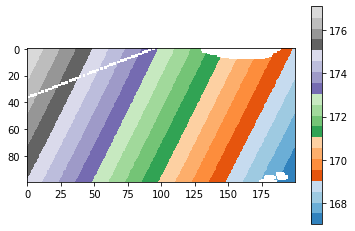

In [147]:
plt.imshow(Scattering_Angle.astype(float),origin='upper',cmap = 'tab20c',interpolation = None)
plt.colorbar()

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

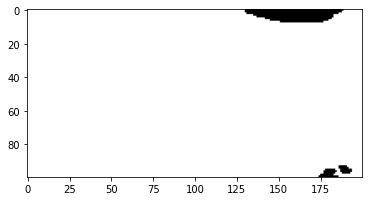

In [145]:
plt.imshow(PART1_MASK,origin='upper',cmap = 'gray',interpolation = None)
plt.colorbar

In [ ]:
PART1_MASK

In [23]:
with open("{}_{}_PL.txt".format(site_name,YYYY),"w") as f:
    for line in MATCH_RESULT:
        f.writelines('\n'.join(line)) 
        f.writelines('\n') 

array([177.09024601689006, 177.04128374600694, 176.99644147606483, ...,
       167.13457168232873, 167.09595060938975, 167.0538783746841],
      dtype=object)